In [1]:
import sys,os
#import setGPU
import numpy as np
import h5py
import random

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('../')))
sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import data_utils.data_processing as data_proc
from data_utils.data_processing import GraphDataset, DenseEventDataset
from training_utils.metrics import cluster_acc
from models.models import GraphAE, IDEC 
from training_utils.training import target_distribution,pretrain_ae_graph, train_test_ae_graph,train_test_idec_graph
from training_utils.activation_funcs  import get_activation_func

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from data_utils.data_processing import GraphDataset,DenseEventDataset
from training_utils.metrics import cluster_acc

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

from sklearn.manifold import TSNE

import matplotlib.colors as colors

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/inputs/clustering_inputs/'
TRAIN_NAME = 'background_with_kl.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['Particles_HLT'])
file_dataset = file_dataset[:,:,[0,1,2,4]] #removing charge for now
truth_dataset = np.array(in_file['PID'])
num_classes=5
particle_id = file_dataset[:,:,[3]]
for p_id in [2,3,4,5]:
    np.place(particle_id, particle_id==p_id, p_id-1)

#have to concatenate truth dataset to the file_dataset
file_dataset = np.concatenate([np.repeat(np.expand_dims(np.expand_dims(truth_dataset,axis=-1),axis=-1),file_dataset.shape[1],axis=1),
                                    particle_id, #pid
                                    file_dataset[:,:,0:3]], #pt,eta,phi
                                    axis=-1)

random.shuffle(file_dataset)
file_dataset = file_dataset[:int(1e5)]
input_shape=[5,4]
n_top_proc=3
batch_size=256

prepared_dataset,datas =  data_proc.prepare_graph_datas(file_dataset,input_shape[0],n_top_proc = n_top_proc,connect_only_real=True)

pid_weight = data_proc.get_relative_weights(prepared_dataset[:,1:,1].reshape(-1),mode='max')
pid_weight = torch.tensor(pid_weight).float().to(device)

train_dataset = GraphDataset(datas)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,drop_last=True) #,num_workers=5


Preparing dataset, check that the feature indexing corresponds to your dataset!
Preparing the dataset of 86711 events
Dataset of 86711 events prepared


/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
list(in_file)
print(in_file['Particles_Classes_HLT'][:])
print(np.unique(prepared_dataset[:,0:,1]))
a = np.place(prepared_dataset[:,1:,1], prepared_dataset[:,1:,1]==2, 1)
#a = np.place(a, a==3, 2)
#a = np.place(a,a==4,3)
print(a)

[b'MET_class_1' b'Ele_class_2' b'Gamma_class_3' b'Mu_class_4'
 b'Jet_class_5']
[0. 1. 2. 3. 4. 5.]
None


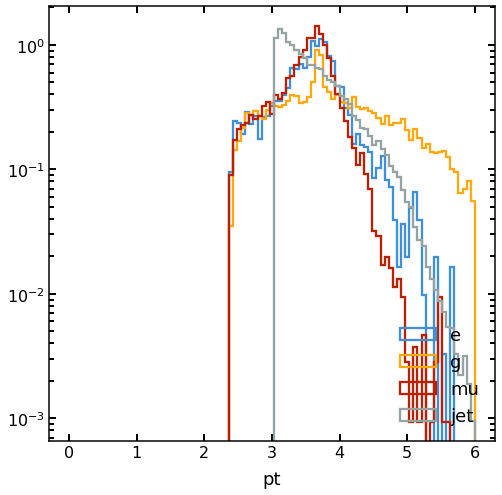

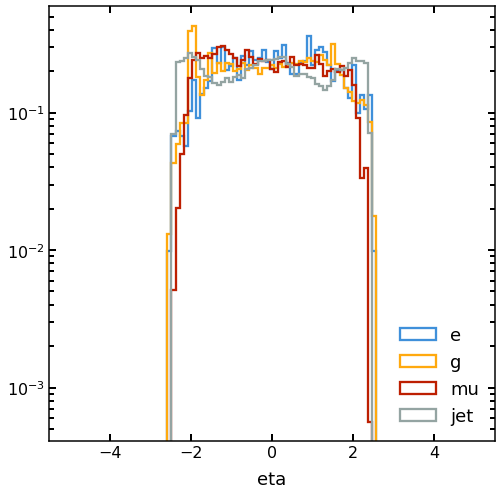

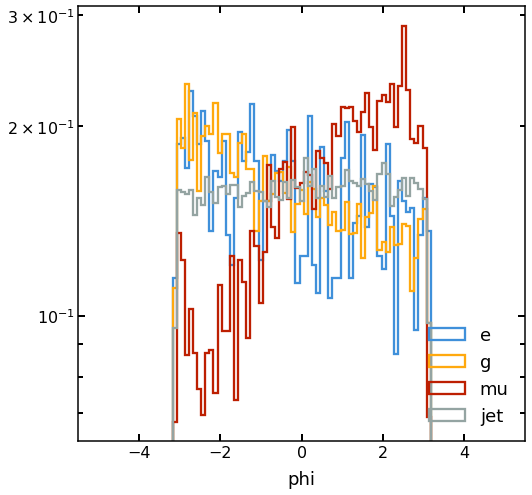

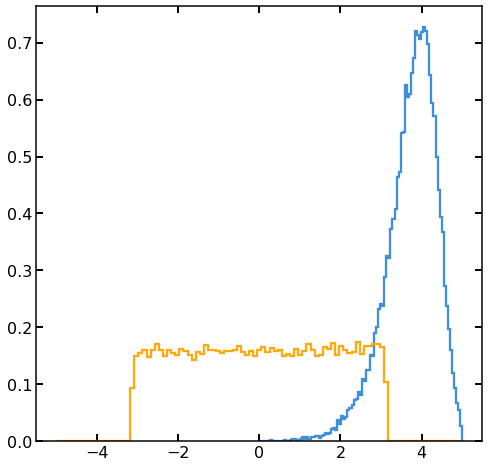

In [30]:

for i,name in zip([2,3,4],'pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,100)
    if i==2:
        bins = np.linspace(0,6,100)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
   # for pid_name, pid in zip(['b','j','mu','g','e'],[2,3,4,5]):
    for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
        _ = plt.hist(prepared_dataset[:,1:,i][prepared_dataset[:,1:,1]==pid],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')
    plt.semilogy()

    
plt.figure(figsize=(8,8))
_ = plt.hist(prepared_dataset[:,0,2],bins=np.linspace(0,5,100),**kwargs)
_ = plt.hist(prepared_dataset[:,0,4],bins=np.linspace(-5,5,100),**kwargs)

In [33]:
import json 
import models.models as models
reload(models)
from models.models import load_DenseAE, load_IDEC, load_GraphAE 

device='cpu'
load_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/trained_output/graph/'
n_run = 'run_3'
load_dir+=n_run+'/'
#path_model_ae = load_dir+'/best_model_AE.pkl'
path_model_ae = load_dir+'/pretrained_AE_epoch_21.pkl'
path_model_idec = load_dir+'/idec_model_epoch_1.pkl'
path_params = load_dir+'parameters.json'
params_dict = json.loads(json.load(open(path_params)))

model_AE = load_GraphAE(params_dict, device, path_model_ae)
#model = load_IDEC(model_AE,params_dict, device, path_model_idec)

In [5]:
num_clusters_dict = {}

num_cluster=3

latent_pred = []
true_labels = []
model.eval() 
    
pred_features = np.array([model.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
pred_features_met = np.array([model.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
latent_pred = np.array([model.forward(d.to(device))[3].data.cpu().numpy() for i,d in enumerate(train_loader)])
pred_labels = np.array([model.forward(data.to(device))[2].data.cpu().numpy().argmax(1) for i,data in enumerate(train_loader)]) #argmax(1) ##index (cluster nubmber) of the cluster with the highest probability q.
true_labels = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader)])
#reshape 
latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))
pred_labels = np.reshape(pred_labels,pred_labels.shape[0]*pred_labels.shape[1])
true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])

acc, nmi, ari,reassignment  = model.validateOnCompleteTestData(true_labels,pred_labels)

print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
#idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
#num_clusters_dict[num_cluster] = {}
#num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
#num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
#num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])


Acc 0.3415 , nmi 0.0002 , ari -0.0001


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


In [34]:
latent_pred = []
true_labels = []
model_AE.eval() 

pred_features = np.array([model_AE.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
pred_features_met = np.array([model_AE.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
latent_pred = np.array([model_AE.forward(d.to(device))[2].data.cpu().numpy() for i,d in enumerate(train_loader)])
true_labels = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader)])
#reshape 
latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))
true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])


In [35]:
#t = file_dataset[:int(1e3),:,2:]
#t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

#t = np.vstack(emb_input)

t = prepared_dataset[:int(1e4),1:,1:]
t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

pred_features_small = pred_features[:,:,num_classes:]

pr_f = np.expand_dims(np.argmax(np.exp(pred_features[:,:,0:num_classes]),axis=-1),axis=-1)
pred_features_small = np.concatenate([pr_f,pred_features[:,:,num_classes:]],axis=-1)

pred_features_2 = pred_features_small.reshape((pred_features_small.shape[0])*pred_features_small.shape[1],pred_features_small.shape[2])

t_met = prepared_dataset[:,0:1,[2,4]]
t_met = t_met.reshape((t_met.shape[0])*t_met.shape[1],t_met.shape[2])
pred_met = pred_features_met.reshape((pred_features_met.shape[0]*pred_features_met.shape[1],pred_features_met.shape[2]))

    

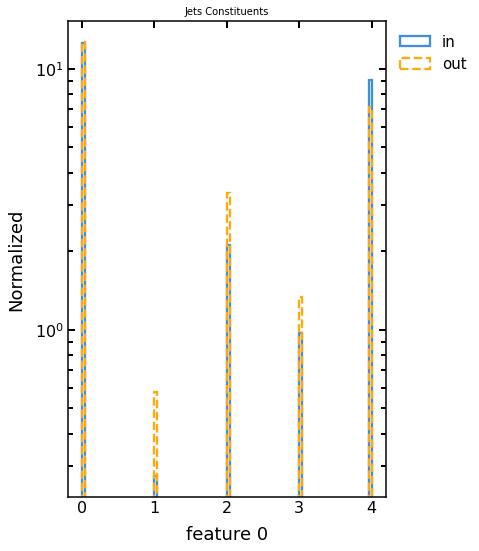

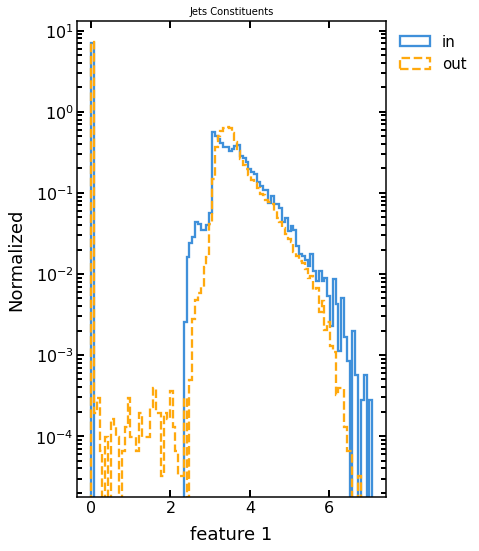

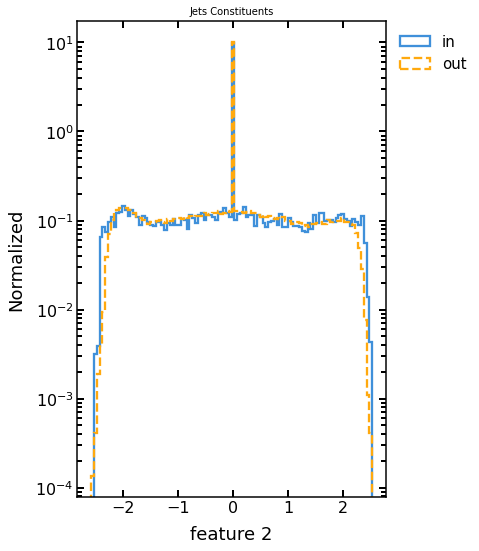

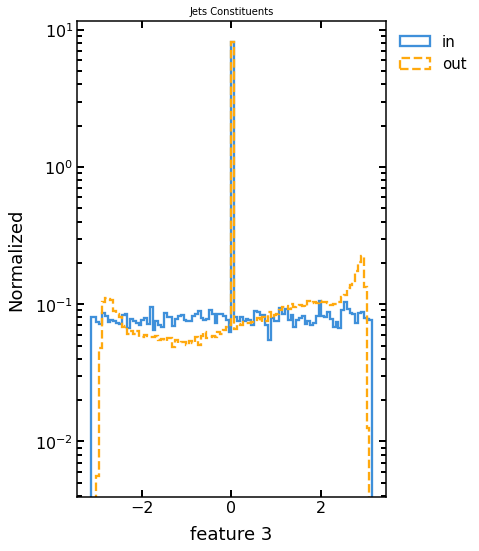

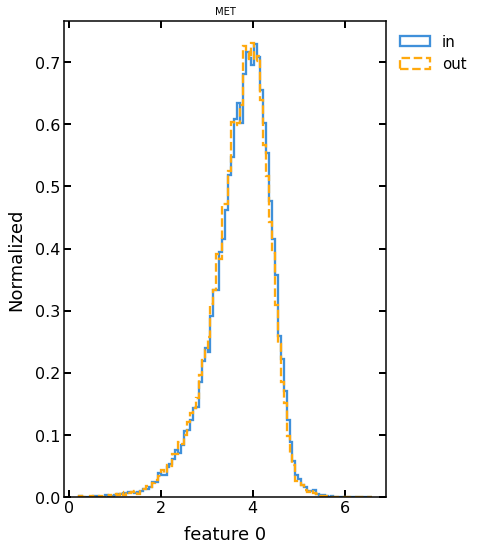

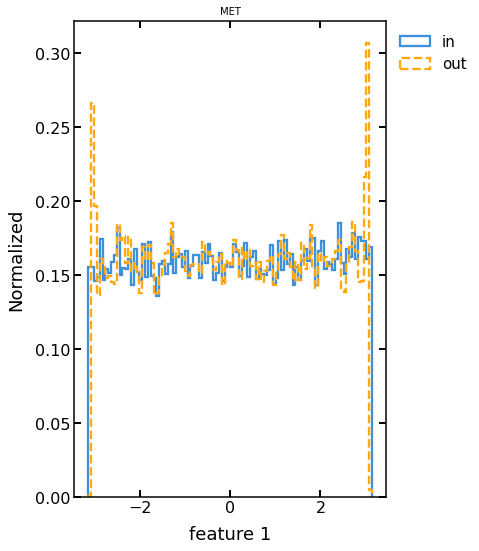

In [36]:
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)


vande_plot.plot_features([t,pred_features_2], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
vande_plot.plot_features([t_met,pred_met], 'feature' ,
                             'Normalized' , 'MET', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=False)

In [14]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


cmap = plt.cm.rainbow #rainbow
nice_colors = ['#3f90da', '#ffa90e', '#94a4a2', '#832db6', '#a96b59', '#e76300', '#b9ac70', '#717581', '#92dadd','#bd1f01']
n_col = int(max(len(np.unique(predicted_reassigned)),len(np.unique(true_labels))))+1
cmap = (colors.ListedColormap(nice_colors[:n_col])
        .with_extremes(over='0.25', under='0.75'))
b_n = np.unique(true_labels)+1 if len(np.unique(true_labels))>len(np.unique(predicted_reassigned)) else np.unique(predicted_reassigned)+1
b_n = np.insert(b_n,0,0)
norm = colors.BoundaryNorm( b_n,cmap.N)


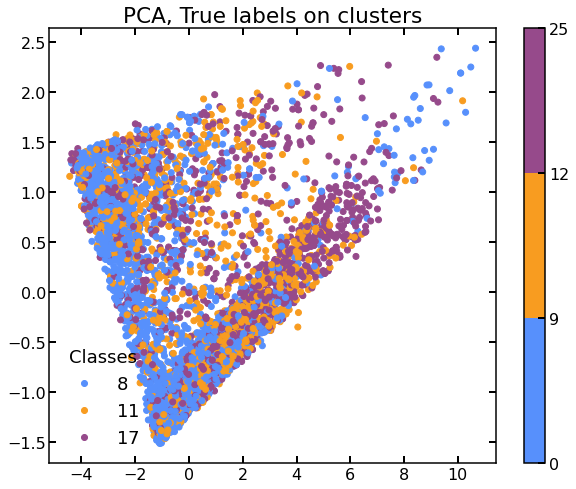

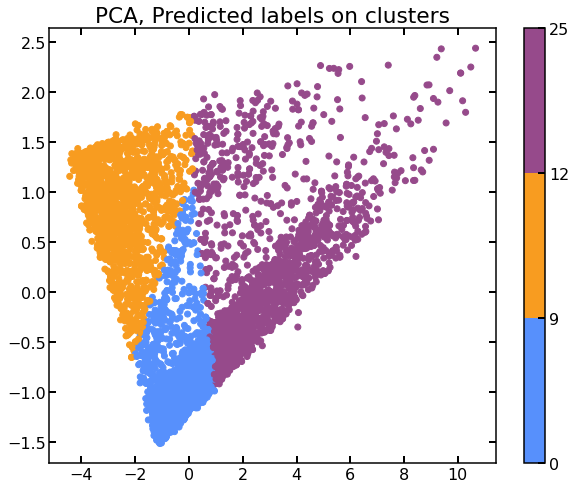

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

n_subsample = 5000
n = int(len(true_labels)/n_subsample)

skf = StratifiedKFold(n, shuffle = True)
for _, batch in skf.split(latent_pred, true_labels):
    break

#principalComponents = TSNE(n_components=2,verbose=1, perplexity=30, n_iter=1000, learning_rate=200
#                          ).fit_transform(latent_pred[batch])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(latent_pred))
pc1 = principalComponents[:,0][batch]
pc2 = principalComponents[:,1][batch]

fig = plt.figure(figsize=(10,8))
scatter = plt.scatter(pc1,pc2, c=true_labels[batch],cmap=cmap, norm=norm)
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

#ax.add_artist(legend1)

fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=np.array(predicted_reassigned)[batch],cmap=cmap, norm=norm)
plt.title('PCA, Predicted labels on clusters')
cb = plt.colorbar()

In [25]:
s0 = pred_features_small.shape[0]
s1 = pred_features_small.shape[1]
s2 = pred_features_small.shape[2]
pred_reshaped = pred_features_small.reshape((s0,batch_size,int(s1/batch_size),s2))
pred_reshaped = pred_reshaped.reshape((pred_reshaped.shape[0]*pred_reshaped.shape[1],pred_reshaped.shape[2],pred_reshaped.shape[3]) )

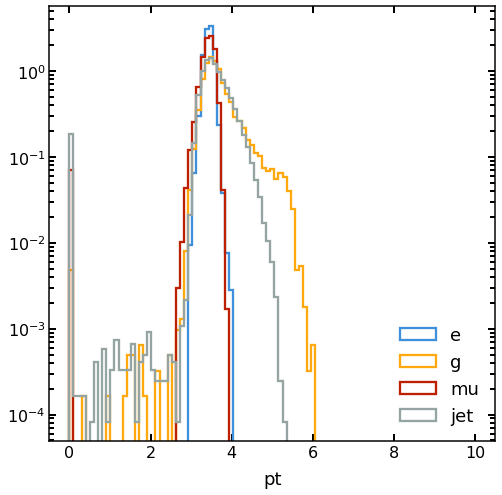

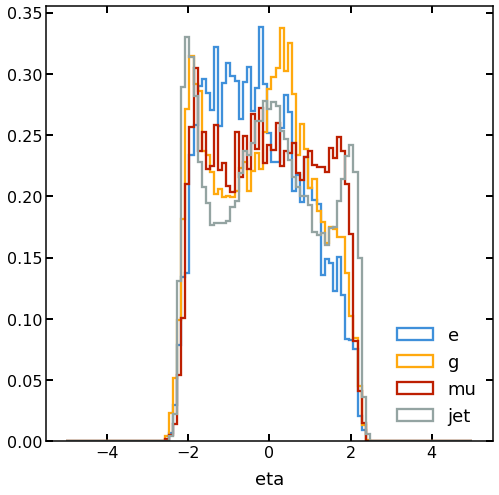

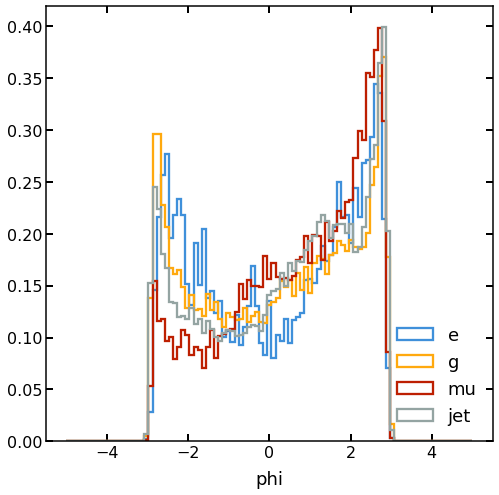

In [31]:
for i,name in zip([1,2,3],'pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,100)
    if i==1:
        bins = np.linspace(0,10,100)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
    #for pid_name, pid in zip(['0','b/j','mu','e/g'],[0,1,2,3]):
    #for pid_name, pid in zip(['0','b','j','mu','g','e'],[0,1,2,3,4,5]):
    for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
        mask = pred_reshaped[:,:,0]==pid
        _ = plt.hist(pred_reshaped[:,:,i][mask],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')
    #plt.semilogy()